Calculate flags for every unit:

1. at least 20 completed trials
2. at least 1hz of mean activity during the fixation period
3. each 50-ms time bin during fixation with nonzero mean activity

Flags are calculated based on binned data (to mimic the paper).

Flags are calculated on the dataset with empty trials (no spikes at all during fixation period!)

[0, 1000] ms portion of the data is used (like in the paper)


I can reproduce the 367 and 318 numbers that I once got (I think I made a mistake). Those numbers are closer to the paper (367 and 317). The number of units in total is different from the paper - paper is 551 and 566 and my dataset is 544 and 543:

steps to reproduce:
1. Load _fixon_1500ms_no_empty_fixation_binned_50ms - whole baseline periods (1500ms) with removed empty trials
2. Take only [0, 1000] ms of it
3. when checking firing rate - divide by 1.5 insted of 1 to get hz

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

In [2]:
data_folder = project_folder_path + 'results\\monkey\\'

fig_folder = project_folder_path + 'results\\monkey\\fig_drafts_paper\\'
save_fig = True

In [10]:
def load_data(area_, data_folder_, verbose_=False):
    csv_data_file = f"{data_folder}data_{area_}_fixon_1000ms_no_empty_fixation_binned_50ms.csv"
    with open(csv_data_file, newline='') as f:
        sua_binned_list = list(csv.reader(f))
    print(f"N spike_trains in {area_}: {len(sua_binned_list)}")
    
    # Convert list to array and then DataFrame
    sua_binned_array = np.array(sua_binned_list)
    bin_cols = [f"bin_{i}" for i in range(sua_binned_array.shape[1] - 5)]
    
    sua_binned_df = pd.DataFrame(
        sua_binned_array, 
        columns=['unit_id', 'trial_id', 'condition_id', 'spike_count', 'fr_hz'] + bin_cols
    )
    
    int_cols = ['unit_id', 'trial_id', 'condition_id', 'spike_count'] + bin_cols
    sua_binned_df[int_cols] = sua_binned_df[int_cols].astype(int)
    sua_binned_df['fr_hz'] = sua_binned_df['fr_hz'].astype(float)
    
    print(f"n units {sua_binned_df['unit_id'].nunique()}")
    return sua_binned_df, bin_cols

In [6]:
def calculate_constraints_df(sua_binned_df_, bin_cols_):
    """
    Apply constraints to dataset:
    - Units with more than 20 trials
    - Each 50-ms time bin during fixation with nonzero mean activity
    - At least 1Hz of mean activity during the fixation period
    """
    # Count trials per unit
    dataset_constraints_df = (sua_binned_df_.groupby('unit_id', as_index=False)['trial_id']
                              .count()
                              .rename(columns={'trial_id': 'n_trials'}))
    dataset_constraints_df['n_trials_more_20'] = dataset_constraints_df['n_trials'] >= 20
    
    print(f"n units with >= 20 trials {dataset_constraints_df['n_trials_more_20'].sum()}")
    
    # Compute mean activity per unit across bins
    trial_mean_activity_df = sua_binned_df_.groupby('unit_id', as_index=False)[bin_cols_].mean()
    
    # Count units where all bins are nonzero
    rows_without_0_unit_id = trial_mean_activity_df[(trial_mean_activity_df[bin_cols_] != 0).all(axis=1)]['unit_id']
    print(f"n rows without 0 bins {len(rows_without_0_unit_id)}")
    # Create a DataFrame for nonzero bins constraint
    non_zero_df = pd.DataFrame({'unit_id': rows_without_0_unit_id, 'no_zero_bins': 1})
    dataset_constraints_df = dataset_constraints_df.merge(non_zero_df, on='unit_id', how='left').fillna(0).astype(int)
    
    # Compute firing rate (Hz) during fixation period
    trial_mean_activity_df['fr_hz'] = trial_mean_activity_df[bin_cols_].sum(axis=1) / 1
    units_more_1hz = trial_mean_activity_df.loc[trial_mean_activity_df['fr_hz'] >= 1, 'unit_id']
    print(f"n rows with more than 1Hz {len(units_more_1hz)}")
    # Create a DataFrame for 1Hz activity constraint
    one_hz_df = pd.DataFrame({'unit_id': units_more_1hz, 'one_hz_activity': 1})
    dataset_constraints_df = dataset_constraints_df.merge(one_hz_df, on='unit_id', how='left').fillna(0).astype(int)
    
    return dataset_constraints_df

In [5]:
def get_reduction_df(constrained_data_acf_binned_1000_df):
    one_c = len(constrained_data_acf_binned_1000_df.query('n_trials_more_20 == True'))
    two_c = len(constrained_data_acf_binned_1000_df.query('n_trials_more_20 == 1 and one_hz_activity == 1'))
    three_c = len(constrained_data_acf_binned_1000_df.query('n_trials_more_20 == 1 and no_zero_bins == 1 and one_hz_activity == 1'))
    
    reduction_df = pd.DataFrame(np.vstack((['0', '1', '2', '3'], [len(constrained_data_acf_binned_1000_df), one_c, two_c, three_c])).T, 
                                columns=['n_constraints', 'n_units'])
    reduction_df['n_constraints'] = reduction_df['n_constraints'].astype(int)
    reduction_df['n_units'] = reduction_df['n_units'].astype(int)
    return reduction_df

### Get the data

In [11]:
pfdl_sua_binned_df, pfdl_bin_cols = load_data(area_='pfdl', data_folder_=data_folder)
pfdl_dataset_constraints_df = calculate_constraints_df(pfdl_sua_binned_df, pfdl_bin_cols)

pfp_sua_binned_df, pfp_bin_cols = load_data(area_='pfp', data_folder_=data_folder)
pfp_dataset_constraints_df = calculate_constraints_df(pfp_sua_binned_df, pfp_bin_cols)

N spike_trains in pfdl: 29367
n units 542
n units with >= 20 trials 470
n rows without 0 bins 382
n rows with more than 1Hz 542
N spike_trains in pfp: 24668
n units 543
n units with >= 20 trials 422
n rows without 0 bins 332
n rows with more than 1Hz 543


In [ ]:
# pfdl_sua_binned_df, pfdl_bin_cols = load_data(area_='pfdl', data_folder_=data_folder)
# pfdl_dataset_constraints_df = calculate_constraints_df(pfdl_sua_binned_df, pfdl_bin_cols[:20])

# pfp_sua_binned_df, pfp_bin_cols = load_data(area_='pfp', data_folder_=data_folder)
# pfp_dataset_constraints_df = calculate_constraints_df(pfp_sua_binned_df, pfp_bin_cols[:20])

In [19]:
# compare with "paper"
temp_folder = project_folder_path + 'results\\monkey\\lab_meeting_snapshot\\fixation_period_1000ms\\'

pfdl_df = pd.read_pickle(temp_folder + 'binned\\pfdl\\acf\\z\\' + 'acf_average_trial_pearsonr_constrained_input_50ms_20lags_df.pkl')
pfp_df = pd.read_pickle(temp_folder + 'binned\\pfp\\acf\\z\\' + 'acf_average_trial_pearsonr_constrained_input_50ms_20lags_df.pkl')

pfdl_current_df = pfdl_dataset_constraints_df.query('n_trials_more_20 == 1 and no_zero_bins == 1 and one_hz_activity == 1').copy()
pfp_current_df = pfp_dataset_constraints_df.query('n_trials_more_20 == 1 and no_zero_bins == 1 and one_hz_activity == 1').copy()

print('pfdl: \n')
subtraction1 = list(set(pfdl_current_df['unit_id'].values) - set(pfdl_df['unit_id'].values))
print("Subtraction current - paper:", subtraction1)
subtraction2 = list(set(set(pfdl_df['unit_id'].values) - set(pfdl_current_df['unit_id'].values)))
print("Subtraction paper - current:", subtraction2)

print('\npfp: \n')
subtraction1 = list(set(pfp_current_df['unit_id'].values) - set(pfp_df['unit_id'].values))
print("Subtraction current - paper:", subtraction1)
subtraction2 = list(set(set(pfp_df['unit_id'].values) - set(pfp_current_df['unit_id'].values)))
print("Subtraction paper - current:", subtraction2)

pfdl: 

Subtraction current - paper: [503, 228, 359, 104, 488, 106, 394, 364, 365, 461, 178, 23, 184, 61, 414]
Subtraction paper - current: [492, 229]

pfp: 

Subtraction current - paper: [265, 304, 337, 18, 433, 277, 22, 439, 440, 188, 254, 95]
Subtraction paper - current: [89, 83]


In [12]:
pfdl_reduction_df = get_reduction_df(pfdl_dataset_constraints_df)
pfdl_reduction_df['area'] = 'pfdl'
pfdl_reduction_df

,n_constraints,n_units,area
0,0,542,pfdl
1,1,470,pfdl
2,2,470,pfdl
3,3,380,pfdl


In [13]:
pfp_reduction_df = get_reduction_df(pfp_dataset_constraints_df)
pfp_reduction_df['area'] = 'pfp'
pfp_reduction_df

,n_constraints,n_units,area
0,0,543,pfp
1,1,422,pfp
2,2,422,pfp
3,3,328,pfp


In [20]:
# save 
pfdl_dataset_constraints_df.to_pickle(data_folder + 'pfdl_dataset_constraints_1000ms_no_empty_df.pkl')
pfp_dataset_constraints_df.to_pickle(data_folder + 'pfp_dataset_constraints_1000ms_no_empty_df.pkl')

### Plot

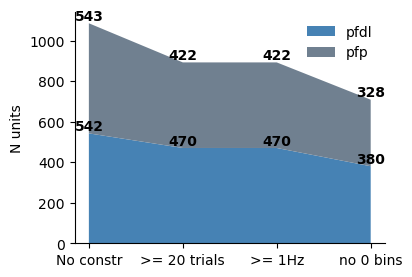

In [14]:
fig, axes = plt.subplots(1,1, figsize=(4,3))

axes.stackplot(pfdl_reduction_df['n_constraints'].values, 
               pfdl_reduction_df['n_units'].values, pfp_reduction_df['n_units'].values, 
               colors =['steelblue', 'slategray'], labels=['pfdl', 'pfp'])

axes.set_xticks([0,1,2,3])
axes.set_xticklabels(['No constr','>= 20 trials','>= 1Hz','no 0 bins'])

axes.set_ylabel('N units')

axes.legend(frameon=False)

for x, y1, y2 in zip(pfdl_reduction_df['n_constraints'], 
                      pfdl_reduction_df['n_units'], 
                      pfp_reduction_df['n_units']):
    axes.text(x, y1, str(y1), ha='center', va='bottom', fontsize=10, color='k', fontweight='bold')
    axes.text(x, y1 + y2, str(y2), ha='center', va='bottom', fontsize=10, color='k', fontweight='bold')

sns.despine()

# if save_fig:
#     fig.savefig(fig_folder + 'constraints_on_data_repr_paper.png', bbox_inches='tight')
#     fig.savefig(fig_folder + 'constraints_on_data_repr_paper.svg', bbox_inches='tight')